# Benchmark Llama2 models on the ClimateX task and dataset

To do this, we will utilize Together.ai for Llama 2 model APIs.



In [1]:
import pandas as pd 
import re
import os


In [2]:
# API Keys - store your TOGETHER_API_KEY in local .env file in this directory
from dotenv import load_dotenv
load_dotenv()


True

In [3]:
df = pd.read_csv('./data/ipcc_statements_dataset.tsv', sep='\t', skiprows=0)

train_set = df.loc[df['split'] == 'train']
test_set = df.loc[df['split'] == 'test']

test_set.head()

,statement_idx,report,page_num,sent_num,statement,confidence,score,split
3,3,AR6_WGI,24,2,"Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,test
42,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...",low,0,test
77,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...",high,2,test
81,81,AR6_WGI,62,2,"Over the past millennium, and especially since...",medium,1,test
86,86,AR6_WGI,63,8,The paleo context supports the assessment that...,high,2,test


In [4]:
from langchain.llms import Together

llm = Together(
    # Select one.
    model = "togethercomputer/llama-2-7b-chat", 
    # model = "togethercomputer/llama-2-13b-chat", 
    # model = "togethercomputer/llama-2-70b-chat", 
    temperature=0.0,
)


## First, use zero-shot prompting (no examples)

In [5]:
ZERO_SHOT_PROMPT = """You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.      

---

Follow the following format.

Statement: ${{a short statement about climate.}}
Confidence: ${{must be *only*: 'low', 'medium', 'high', 'very high'}}

---

Statement: {input}
Confidence: """

### One example

In [6]:
def get_zero_shot_confidence(llm, prompt, statement, verbose=False):
    complete_prompt = prompt.format(input=statement)
    text = llm(complete_prompt)
    if verbose:
        print("--PROMPT--")
        print(complete_prompt)
        print()

        print("--MODEL RESPONSE--")
        print(text)
        print("--FINAL PARSED OUTPUT CONFIDENCE PREDICTION--")

    # extract single-word confidence rating
    if re.search(r"low", text, re.IGNORECASE):
        return "low"
    elif re.search(r"medium", text, re.IGNORECASE):
        return "medium"
    elif re.search(r"very high", text, re.IGNORECASE):
        return "very high"
    elif re.search(r"high", text, re.IGNORECASE):
        return "high"
    elif re.search(r"i don't know", text, re.IGNORECASE):
        return "idk"
    else:
        return "N/A"

example = train_set['statement'].sample(1)
example = example.values[0]
get_zero_shot_confidence(llm, ZERO_SHOT_PROMPT, example, verbose=True)

--PROMPT--
You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.      

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Changing seasonality, increasing frequency of drought and rising temperatures are 

'high'

## Run on the entire test set, save results

In [7]:
samples = test_set.copy()

samples['prediction'] = samples.statement.apply(lambda x: get_zero_shot_confidence(llm, ZERO_SHOT_PROMPT, x))

In [8]:
samples['correct'] = samples.apply(
    lambda row: (row['confidence'] == row['prediction']), axis=1)

print(f"Accuracy: {samples['correct'].sum() / (samples.shape[0]-len(samples[samples['prediction'] == 'idk'])):.3f}")
print(f"'I don't know': {len(samples[samples['prediction'] == 'idk'])}")
print(f"N/A: {len(samples[samples['prediction'] == 'N/A'])}")

Accuracy: 0.355
'I don't know': 18
N/A: 18


In [9]:
samples.to_csv('./results/llama-2-chat-7b-zeroshot-temp0-2023-12-21.csv', index=False)

In [10]:
display(samples[samples['prediction'] == 'idk'])

,statement_idx,report,page_num,sent_num,statement,confidence,score,split,prediction,correct
151,151,AR6_WGI,85,31,Model estimates suggest no significant change ...,low,0,test,idk,False
663,663,AR6_WGI,365,4,Permafrost that formed after 3ka still persist...,medium,1,test,idk,False
671,671,AR6_WGI,369,32,The fastest rise occurred during Meltwater Pul...,medium,1,test,idk,False
772,772,AR6_WGI,495,14,The structure of the salinity biases in the mu...,medium,1,test,idk,False
795,795,AR6_WGI,522,23,The pattern of ocean salinity changes indicate...,high,2,test,idk,False
1259,1259,AR6_WGI,1075,9,"Non-linear responses of regional runoff, groun...",medium,1,test,idk,False
1957,1957,AR6_WGI,1848,19,The mean wind speeds decline in North America ...,low,0,test,idk,False
2525,2525,AR6_WGII,42,16,Climate resilient development in urban areas a...,medium,1,test,idk,False
3418,3418,AR6_WGII,288,2,While this has not yet been systematically exp...,low,0,test,idk,False
4439,4439,AR6_WGII,790,13,Mangrove reforestation efforts in Asia may hav...,low,0,test,idk,False


In [11]:
display(samples[samples['prediction'] == 'N/A'])

,statement_idx,report,page_num,sent_num,statement,confidence,score,split,prediction,correct
980,980,AR6_WGI,742,14,One study inferred a multi-year net CO2 source...,low,0,test,N/A,False
2191,2191,AR6_WGI,2003,4,The assessment found that the volume of ice in...,high,2,test,N/A,False
2196,2196,AR6_WGI,2007,20,"According to AR5 (Christensen et al., 2013), s...",high,2,test,N/A,False
3071,3071,AR6_WGII,107,25,Adaptation and mitigation approaches that exac...,high,2,test,N/A,False
3426,3426,AR6_WGII,302,5,There are substantial non-climatic drivers (LU...,high,2,test,N/A,False
3428,3428,AR6_WGII,303,16,"The area of coastline suitable for Cholera, De...",low,0,test,N/A,False
3553,3553,AR6_WGII,411,17,Temperature affects the movement and transport...,very high,3,test,N/A,False
3788,3788,AR6_WGII,444,4,"While levels of pollutants in biota (e.g., per...",medium,1,test,N/A,False
4253,4253,AR6_WGII,667,2,Water-related technologies can also have adver...,medium,1,test,N/A,False
4541,4541,AR6_WGII,839,2,Limited global land and biomass resources acco...,high,2,test,N/A,False


## Precision, recall, and F1 score

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

true_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'confidence']
predicted_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'prediction']

# Compute macro F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("Macro F1 score:", f1)

# Compute weighted F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("Weighted F1 score:", f1)

# Compute precision for each class
precision = precision_score(true_labels, predicted_labels, average=None)

# Compute recall for each class
recall = recall_score(true_labels, predicted_labels, average=None)

# Compute F1 score for each class
f1 = f1_score(true_labels, predicted_labels, average=None)

# Create a dataframe to store precision and recall for each class
class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

# Add labels to the class metrics dataframe
class_metrics_df['Class'] = true_labels.unique().astype(str)

# Sort the dataframe by class index or name
class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

# Print class metrics dataframe
#print(class_metrics_df)

# Compute accuracy for the whole system
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute accuracy by class

print("Accuracy (total):", accuracy)

report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

# Count classes
category_counts = true_labels.value_counts()
print(category_counts)



Macro F1 score: 0.2614894889485054
Weighted F1 score: 0.3208823065380443
Accuracy (total): 0.3787878787878788
              precision    recall  f1-score   support

        high     0.3964    0.7444    0.5174        90
         low     0.2105    0.0952    0.1311        42
      medium     0.4000    0.3256    0.3590        86
   very high     0.1667    0.0217    0.0385        46

    accuracy                         0.3788       264
   macro avg     0.2934    0.2968    0.2615       264
weighted avg     0.3280    0.3788    0.3209       264

confidence
high         90
medium       86
very high    46
low          42
Name: count, dtype: int64


## Over/under confidence assessment

In [13]:
# Filter samples
fs = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk')] 

# Compute a certainty score
value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3}

fs['predicted_score'] = fs.prediction.apply(
    lambda x: value_map[x])

# Break down scores
scores_all = {
    "low": fs.loc[fs['score'] == 0, 'predicted_score'].mean(),
    "medium": fs.loc[fs['score'] == 1, 'predicted_score'].mean(),
    "high": fs.loc[fs['score'] == 2, 'predicted_score'].mean(),
    "very high": fs.loc[fs['score'] == 3, 'predicted_score'].mean()
}

scores_wg1 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean()
}

scores_wg23 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean()
}

print("=== All AR6 reports===")
print(f"Average ground truth score: {samples['score'].mean()}")
print(f"Average predicted score: {fs['predicted_score'].mean()}")
print(f"Average scores per category: {scores_all}\n")

print("=== AR6 WGI report ===")
print(f"Average ground truth score: {samples.loc[samples['report'] == 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] == 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg1}\n")

print("=== AR6 WGII/III reports ===")
print(f"Average ground truth score: {samples.loc[samples['report'] != 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] != 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg23}\n")

=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.6136363636363635
Average scores per category: {'low': 1.3333333333333333, 'medium': 1.5232558139534884, 'high': 1.7777777777777777, 'very high': 1.7173913043478262}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.6823529411764706
Average scores per category: {'low': 1.4705882352941178, 'medium': 1.5483870967741935, 'high': 1.8888888888888888, 'very high': 1.9}

=== AR6 WGII/III reports ===
Average ground truth score: 1.5853658536585367
Average predicted score: 1.5810055865921788
Average scores per category: {'low': 1.24, 'medium': 1.509090909090909, 'high': 1.7301587301587302, 'very high': 1.6666666666666667}



/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_25441/201967900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fs['predicted_score'] = fs.prediction.apply(


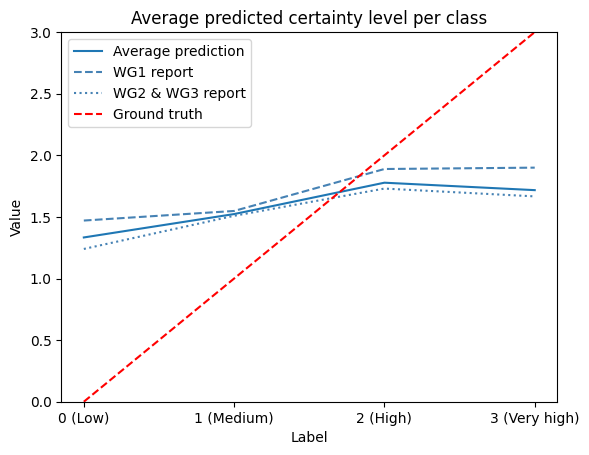

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the data

# Extract labels and values from the data dictionary
labels = list(scores_all.keys())
values_all = list(scores_all.values())
values_wg1 = list(scores_wg1.values())
values_wg23 = list(scores_wg23.values())

# Define the custom labels for the x-axis
x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

# Create the line plot with labeled curve
sns.lineplot(x=labels, y=values_all, label='Average prediction')
sns.lineplot(x=labels, y=values_wg1, linestyle='--', color="steelblue", label='WG1 report')
sns.lineplot(x=labels, y=values_wg23, linestyle='dotted', color="steelblue", label='WG2 & WG3 report')


# Add the ground truth line (y = x)
x = np.arange(len(labels))
plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

# Customize the x-axis tick labels
plt.xticks(labels, x_labels)

# Set the y-axis limits
plt.ylim(0, 3)

# Set the title and labels
plt.title("Average predicted certainty level per class")
plt.xlabel("Label")
plt.ylabel("Value")

# Show the legend
plt.legend()

# Show the plot
plt.show()

## Try Few-shot prompting

In [15]:
FEW_SHOT_PROMPT = """You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.      

---

Follow the following format.

Statement: ${{a short statement about climate.}}
Confidence: ${{must be *only*: 'low', 'medium', 'high', 'very high'}}

---
{examples}

Statement: {input}
Confidence: """

In [16]:
EXAMPLE_TEMPLATE = """
Statement: {example_statement}
Confidence: {example_label}
"""

### One prompt example

In [17]:
def get_few_shot_confidence(llm, prompt, example_template, statement, n_examples=3, verbose=False):
    assert n_examples > 0, "Please use n_examples > 0 or choose get zero_shot_confidence"
    selected_examples = train_set.sample(n_examples)
    examples = ""
    for e, l in zip(selected_examples.statement, selected_examples.confidence):
        examples += example_template.format(example_statement = e, example_label=l)
    
    complete_prompt = prompt.format(examples=examples, input=statement)
    text = llm(complete_prompt)
    if verbose:
        print("--PROMPT--")
        print(complete_prompt)
        print()

        print("--MODEL RESPONSE--")
        print(text)
        print("--FINAL PARSED OUTPUT CONFIDENCE PREDICTION--")

    # extract single-word confidence rating
    if re.search(r"low", text, re.IGNORECASE):
        return "low"
    elif re.search(r"medium", text, re.IGNORECASE):
        return "medium"
    elif re.search(r"very high", text, re.IGNORECASE):
        return "very high"
    elif re.search(r"high", text, re.IGNORECASE):
        return "high"
    elif re.search(r"i don't know", text, re.IGNORECASE):
        return "idk"
    else:
        return "N/A"

statement = train_set['statement'].sample(1)
statement = statement.values[0]
get_few_shot_confidence(llm, FEW_SHOT_PROMPT, EXAMPLE_TEMPLATE, statement, n_examples = 3, verbose=True)

--PROMPT--
You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.      

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Regardless of the reasons and the initiators for migration, community control over

'very high'

## Run on the entire test set, save results

In [18]:

samples = test_set.copy()

samples['prediction'] = samples.statement.apply(lambda x: get_few_shot_confidence(llm, FEW_SHOT_PROMPT, EXAMPLE_TEMPLATE, x, n_examples = 3))

In [19]:
samples['correct'] = samples.apply(
    lambda row: (row['confidence'] == row['prediction']), axis=1)

print(f"Accuracy: {samples['correct'].sum() / (samples.shape[0]-len(samples[samples['prediction'] == 'idk'])):.3f}")
print(f"'I don't know': {len(samples[samples['prediction'] == 'idk'])}")
print(f"N/A: {len(samples[samples['prediction'] == 'N/A'])}")

Accuracy: 0.326
'I don't know': 42
N/A: 0


In [20]:
samples.to_csv('./results/llama-2-chat-7b-fewshot-temp0-2023-12-21.csv', index=False)

## Precision, recall, and F1 score

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

true_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'confidence']
predicted_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'prediction']

# Compute macro F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("Macro F1 score:", f1)

# Compute weighted F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("Weighted F1 score:", f1)

# Compute precision for each class
precision = precision_score(true_labels, predicted_labels, average=None)

# Compute recall for each class
recall = recall_score(true_labels, predicted_labels, average=None)

# Compute F1 score for each class
f1 = f1_score(true_labels, predicted_labels, average=None)

# Create a dataframe to store precision and recall for each class
class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

# Add labels to the class metrics dataframe
class_metrics_df['Class'] = true_labels.unique().astype(str)

# Sort the dataframe by class index or name
class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

# Print class metrics dataframe
#print(class_metrics_df)

# Compute accuracy for the whole system
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute accuracy by class

print("Accuracy (total):", accuracy)

report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

# Count classes
category_counts = true_labels.value_counts()
print(category_counts)



Macro F1 score: 0.3244601449108895
Weighted F1 score: 0.3281796894886733
Accuracy (total): 0.32558139534883723
              precision    recall  f1-score   support

        high     0.6786    0.2088    0.3193        91
         low     0.2000    0.4359    0.2742        39
      medium     0.3857    0.3176    0.3484        85
   very high     0.2800    0.4884    0.3559        43

    accuracy                         0.3256       258
   macro avg     0.3861    0.3627    0.3245       258
weighted avg     0.4433    0.3256    0.3282       258

confidence
high         91
medium       85
very high    43
low          39
Name: count, dtype: int64


## Over/under confidence assessment

In [22]:
# Filter samples
fs = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk')] 

# Compute a certainty score
value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3}

fs['predicted_score'] = fs.prediction.apply(
    lambda x: value_map[x])

# Break down scores
scores_all = {
    "low": fs.loc[fs['score'] == 0, 'predicted_score'].mean(),
    "medium": fs.loc[fs['score'] == 1, 'predicted_score'].mean(),
    "high": fs.loc[fs['score'] == 2, 'predicted_score'].mean(),
    "very high": fs.loc[fs['score'] == 3, 'predicted_score'].mean()
}

scores_wg1 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean()
}

scores_wg23 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean()
}

print("=== All AR6 reports===")
print(f"Average ground truth score: {samples['score'].mean()}")
print(f"Average predicted score: {fs['predicted_score'].mean()}")
print(f"Average scores per category: {scores_all}\n")

print("=== AR6 WGI report ===")
print(f"Average ground truth score: {samples.loc[samples['report'] == 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] == 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg1}\n")

print("=== AR6 WGII/III reports ===")
print(f"Average ground truth score: {samples.loc[samples['report'] != 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] != 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg23}\n")

=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.3604651162790697
Average scores per category: {'low': 0.8974358974358975, 'medium': 1.1764705882352942, 'high': 1.5274725274725274, 'very high': 1.7906976744186047}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.4268292682926829
Average scores per category: {'low': 0.875, 'medium': 1.1666666666666667, 'high': 1.8076923076923077, 'very high': 2.1}

=== AR6 WGII/III reports ===
Average ground truth score: 1.5853658536585367
Average predicted score: 1.3295454545454546
Average scores per category: {'low': 0.9130434782608695, 'medium': 1.1818181818181819, 'high': 1.4153846153846155, 'very high': 1.696969696969697}



/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_25441/201967900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fs['predicted_score'] = fs.prediction.apply(


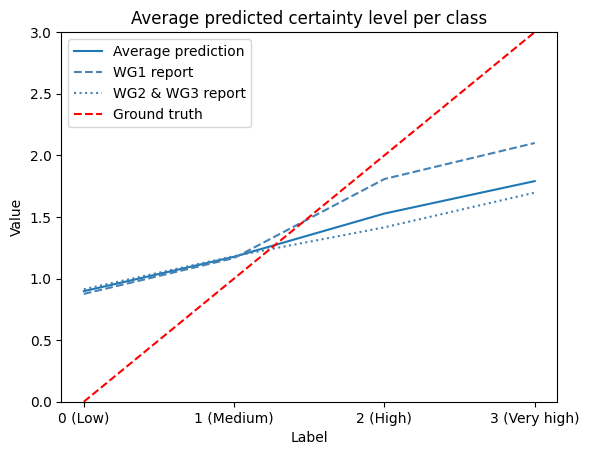

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the data

# Extract labels and values from the data dictionary
labels = list(scores_all.keys())
values_all = list(scores_all.values())
values_wg1 = list(scores_wg1.values())
values_wg23 = list(scores_wg23.values())

# Define the custom labels for the x-axis
x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

# Create the line plot with labeled curve
sns.lineplot(x=labels, y=values_all, label='Average prediction')
sns.lineplot(x=labels, y=values_wg1, linestyle='--', color="steelblue", label='WG1 report')
sns.lineplot(x=labels, y=values_wg23, linestyle='dotted', color="steelblue", label='WG2 & WG3 report')


# Add the ground truth line (y = x)
x = np.arange(len(labels))
plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

# Customize the x-axis tick labels
plt.xticks(labels, x_labels)

# Set the y-axis limits
plt.ylim(0, 3)

# Set the title and labels
plt.title("Average predicted certainty level per class")
plt.xlabel("Label")
plt.ylabel("Value")

# Show the legend
plt.legend()

# Show the plot
plt.show()